In [1]:
cd ..

/home/jonas_h/ch4_py/notebooks/Time Series Analysis/dlm_helper


# Calculating global annual methane increases from satellite data using an ensemble dynamic linear model approach
This notebook contains example code to calculate and plot global annual methane increases derived from Sentinel-5P TROPOMI WFDM XCH$_4$ data.

**Version** : 1.0

**DOI**: /

**Requirements** :
- The gridded WFMDv1.8 data can be downloaded from [10.5281/zenodo.8185672](https://doi.org/10.5281/zenodo.8185672)
- The following python packages need to be installed
    - xarray
    - netcdf4
    - numpy
    - matplotlib
    - tabulate
    - statsmodels
    - cartopy (optional)

## Import packages

In [2]:
import os
import datetime

import xarray as xr
import numpy as np 

import matplotlib.pyplot as plt
import matplotlib.dates

# Uncomment if you have installed cartopy
# import cartopy.crs as ccrs
# import cartopy.feature as cf


import dlmhelper.tools
import dlmhelper.data
#from dlmhelper.spatio_temporal import inhomogeneity_spatial, inhomogeneity_temporal


## Function definitons
These functions handle the reading, gridding and saving of .nc files

In [3]:
def load_grid_from_netcdf(d1,m1,y1,d2,m2,y2,path,grid_dim=None):
    """
    Loads gridded data from NetCDF file for further processing. Sorts the data and adds missing
    days.
    
    Parameters:
        d1 (int): Day of the month for the start date (1-31).
        m1 (int): Month of the start date (1-12).
        y1 (int): Year of the start date.
        d2 (int): Day of the month for the end date (1-31).
        m2 (int): Month of the end date (1-12).
        y2 (int): Year of the end date.
        path (str): Path to NetCDF file
        grid_dim (array-like, optional): Area to be read formatted as
            [lat_low, lat_high, lon_low, lon_high]
            
    Returns:
        np.array: Average XCH4 for each grid cell with shape (LAT,LON,TIME)
        np.array: XCH4 uncertainty for each grid cell with shape (LAT,LON,TIME)
        np.array: Number of datapoints used for each grid cell with shape (LAT,LON,TIME)
        np.array: Latitudes for the lower boundary of the grid cells with shape (LAT)
        np.array: Longitudes for the lower boundary of the grid cells with shape (LON)
        np.array: Time as days since 1970-1-1 with shape (TIME)
        np.array: Information about the grid formatted as
                [lat_low, lat_high, lon_low, lon_high, lat_step, lon_step]
        str: String containing the name of the product
    

    """
    
    date_min=(datetime.datetime(y1,m1,d1)-datetime.datetime(1970,1,1)).days
    date_max=(datetime.datetime(y2,m2,d2)-datetime.datetime(1970,1,1)).days

    ds = xr.load_dataset(path)
    
    product_type = ds.attrs['product_type']
    LAT_LOW = ds.attrs['lat_low']
    LAT_HIGH = ds.attrs['lat_high']
    LON_LOW = ds.attrs['lon_low']
    LON_HIGH = ds.attrs['lon_high']
    LAT_STEP = ds.attrs['lat_res']
    LON_STEP = ds.attrs['lon_res']
    latd=int((LAT_HIGH-LAT_LOW)/LAT_STEP)
    lond=int((LON_HIGH-LON_LOW)/LON_STEP)
    sdev=np.zeros((latd,lond))
    xch4 = np.zeros((latd,lond))
    
    x = ds.variables['lon']
    y = ds.variables['lat']
    d = ds.variables['day']
    
    ref_time = ds.attrs['reference_time']
    
    
    if grid_dim is not None:
        lat_min, lat_max, lon_min, lon_max = grid_dim
    else:
        lat_min,lat_max,lon_min,lon_max = LAT_LOW, LAT_HIGH, LON_LOW, LON_HIGH
    
    a = (y>=lat_min) & (y<lat_max)
    b = (x>=lon_min) & (x<lon_max)
    xch4 = ds.variables['xch4'][a,b,(d>=date_min) & (d<=date_max)]
    sdev = ds.variables['xch4_err'][a,b,(d>=date_min) & (d<=date_max)]
    N = ds.variables['N'][a,b,(d>=date_min) & (d<=date_max)]
    
    d=d[(d>=date_min) & (d<=date_max)]
    
    x = x[b]
    y = y[a]

    ds.close()
    
    grid_dim = {
        'LAT_LOW': lat_min,
        'LAT_HIGH': lat_max, 
        'LON_LOW': lon_min,
        'LON_HIGH': lon_max,
        'LAT_STEP': LAT_STEP,
        'LON_STEP': LON_STEP
    }
    return xch4, sdev, N, x.values, y.values, d, grid_dim, product_type , ref_time

## Settings

First the area and time ranges to be read from the NetCDF file are defined
- <b> grid </b> <i>(LAT_LOW, LAT_HIGH, LON_LOW, LON_HIGH)</i>: Defines the subgrid to be read from the file
- <b> d1, m1, y1, d2, m2, y2 </b>: Define the start and end date for the time series
- <b> dd1, md1, yd1, dd2, md2, yd2 </b>: Define the start and end date for which the data will be loaded

We define a time series from 2018-01 to 2023-03 only using data from 2018-05 to 2023-03. While data is theoretically available from 2017-11, the commisioning phase of the S5P mission ended with 2018-05, thus we only use data starting from this point.

In [4]:
#Area to be loaded from the NetCDF file
grid=[-90,90,-180,180]

#These dates define the start and end date for the time series
d1, m1, y1 = (1,1,2018)
d2, m2, y2 = (1,3,2023)

#These dates the start and end date for which data form the NetCDF file shall be used
dd1, md1, yd1 = (1,5,2018)
dd2, md2, yd2 = (1,3,2023)

path_in = "/home/jonas_h/output/processed/global_grid/2x2_WFMDv18_64bit/global_2x2_64_xch4_trend_LAT_-90.00_90.00_LON_-180.00_180.00.nc"

In [5]:
name = "global" # Name used when saving DLM fit resuts
FOLDS = 5       # Number of folds to use for cross validation
ZONAL_AVG = True # If true, average over longitudes first and latitudes second. This helps to reduce sampling related biases.

path_out = "./" # Path to save DLMResults and final plot

## Load data
The gridded data is loaded from the NetCDF file using the determined date range and area.

In [6]:
date_min = (datetime.datetime(y1,m1,d1)-datetime.datetime(1970,1,1)).days
date_max = (datetime.datetime(y2,m2,d2)-datetime.datetime(1970,1,1)).days

vmr, sdev, N, lons, lats, d, grid_dim, product_type, ref_time = load_grid_from_netcdf(d1,m1,y1,d2,m2,y2,path_in,grid_dim=grid)

data_min = (datetime.datetime(yd1,md1,dd1)-datetime.datetime(1970,1,1)).days
data_max = (datetime.datetime(yd2,md2,dd2)-datetime.datetime(1970,1,1)).days
    
_idx = (d<data_min) | (d>data_max)
vmr[:,:,_idx] = np.nan
sdev[:,:,_idx] = np.nan

In [10]:
grid_data = dlmhelper.data.Grid(vmr, lats, lons, time= d,time_unit = "day",error=sdev, N = N, reference_time = ref_time, grid_dim = grid_dim, product_type="WFMDv1.8")

## Pre-processing of data
Here the gridded data is filtered using the spatial and temporal homogeneity measure from [Sofieva et al. (2014)](https://www.doi.org/10.5194/amt-7-1891-2014).
This removes grid cells with inhomogeneous temporal coverage and days with inhomogeneous spatial coverage from the analysis.

In [11]:
HT_LIM = 0.5 
Ht = grid_data.inhomogeneity_temporal()
grid_data.filter_inhomogeneity_temporal(ht_lim=HT_LIM)

_To visualize the temporal inhomogeneity nicely the cartopy package is needed_

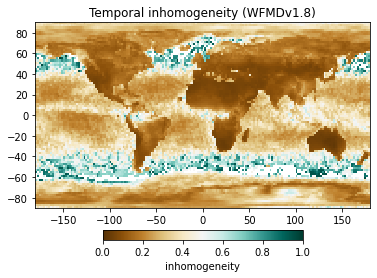

In [12]:
LAT_LOW = grid_dim["LAT_LOW"]
LAT_HIGH = grid_dim["LAT_HIGH"]
LON_LOW = grid_dim["LON_LOW"]
LON_HIGH = grid_dim["LON_HIGH"]
LAT_STEP = grid_dim["LAT_STEP"]
LON_STEP = grid_dim["LON_STEP"]

import sys

cmap = "BrBG"

if 'cartopy' in sys.modules:
    
    fig = plt.figure()
    proj=ccrs.PlateCarree()
    proj._threshold /= 100.
    ax = fig.add_subplot(111,projection=proj)
    ax.add_feature(cf.COASTLINE)
    ax.gridlines(draw_labels=True)
    ax.set_extent([LON_LOW,LON_HIGH,LAT_LOW,LAT_HIGH],ccrs.PlateCarree())

    X2=list(lats)
    X2.append(X2[-1]+LON_STEP)
    Y2=list(lons)
    Y2.append(Y2[-1]+LAT_STEP)
    X2=np.asarray(X2)
    Y2=np.asarray(Y2)

    X=lons
    Y=lats
    XX,YY=np.meshgrid(Y2,X2)
    ht_masked = np.ma.masked_equal(Ht[...,0],0)

    plt.title(f'Temporal inhomogeneity ({product_type})') 
    vmin = 0
    vmax = 1
    cm=plt.pcolormesh(XX,YY,ht_masked,shading='auto',cmap=cmap,transform=ccrs.PlateCarree(),vmin=vmin,vmax = vmax)

    cb=fig.colorbar(cm,fraction=0.046,pad=0.1,orientation='horizontal')
    cb.set_label(r'inhomogeneity')

else:
    
    fig = plt.figure()
    ax = fig.add_subplot(111)

    X2=list(lats)
    X2.append(X2[-1]+LON_STEP)
    Y2=list(lons)
    Y2.append(Y2[-1]+LAT_STEP)
    X2=np.asarray(X2)
    Y2=np.asarray(Y2)

    X=lons
    Y=lats
    XX,YY=np.meshgrid(Y2,X2)
    ht_masked = np.ma.masked_equal(Ht[...,0],0)

    plt.title(f'Temporal inhomogeneity ({product_type})') 
    vmin = 0
    vmax = 1
    cm=plt.pcolormesh(XX,YY,ht_masked,shading='auto',cmap=cmap,vmin=vmin,vmax = vmax)

    cb=fig.colorbar(cm,fraction=0.046,pad=0.1,orientation='horizontal')
    cb.set_label(r'inhomogeneity')

Calculate & plot spatial homogeneity

In [13]:
Hs = grid_data.inhomogeneity_spatial()

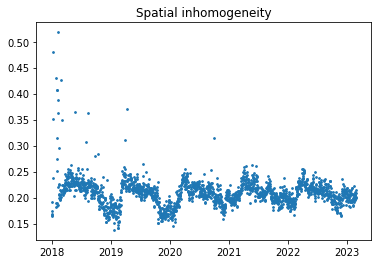

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Spatial inhomogeneity")
ax.scatter(grid_data.time,Hs[:,0],s=3)
#ax.axhline(0.2639240547142875,color='black')
ax.xaxis_date()

Filter the grid_data object using spatial homogeneity and the standard limit $H_s^{lim} = $ median + 2 x $\sigma$

In [ ]:
grid_data.filter_inhomogeneity_spatial()

Filter data with low spatial homogeneity

Calculate the time series as the area-weighted average from the processed gridded data

In [15]:
time_series = grid_data.to_timeseries(zonal_avg=True)

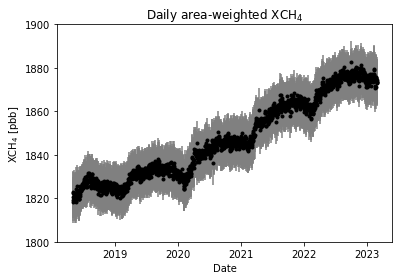

In [19]:
product_type = time_series.product_type
vmr_whmean, sdev_whmean = time_series.data, time_series.error
d = time_series.time

vmr_min = np.nanmin(vmr_whmean)-5; vmr_max=np.nanmax(vmr_whmean)+5

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(d,vmr_whmean,yerr=sdev_whmean,color='black',ecolor='gray',ls='',marker='.')
ax.set_title(f"Daily area-weighted XCH$_4$")
ax.set_xlabel("Date")
ax.set_ylabel(f"XCH$_4$ [pbb]")
ax.set_ylim(1800,1900)
ax.xaxis_date()

In [20]:
time_series.save('./',"WFMD_TimeSeries.dat")

Saved data at: ./TimeSeries_WFMD_TimeSeries.dat.json


In [6]:
time_series = dlmhelper.data.TimeSeries.load('./WFMD_TimeSeries.dat')

## Dynamic linear model fit
The daily area-weighted XCH4 data is fitted using a dynamic linear model approach. 
For this an ensemble of different DLMs is fitted to the data. Additonally, cross validation is performed from which an average mean squared error (AMSE) is determined for each model.

The AMSE is used together with the variance of the level and seasonal component of the DLM fits to create an aggregated measure (agg) for model selection.
The final model is used to calculate the global annual methane increases.
### Create Folds

In [7]:
scores = dlmhelper.tools.cv_dlm_ensemble(time_series,
                        level = [True], variable_level= [False],
                        trend = [True], variable_trend= [True],
                        seasonal = [True],
                        seasonal_period=[[365.2]],
                        seasonal_harmonics=[
                            [[1,2,3,4]]
                        ],
                        variable_seasonal= [
                                [[True, False]]
                            ],
                        irregular=[True,False],
                        autoregressive = [1],
                        folds = 5
                        )

KeyboardInterrupt: 

In [ ]:
dlm_results =  dlmhelper.tools.dlm_ensemble(time_series, name="wfmd_global_ensemble",
                                            seasonal_period=[[365.2]],
                                            seasonal_harmonics=[
                                                [[1,2,3,4]]
                                            ],
                                            variable_seasonal= [
                                                    [[True, False]]
                                                ],
                                            irregular=[True,False], scores=scores)

In [25]:
dlm_results.summary(converged=True, sort='agg')

| Model               | converged   |     aic |       ll |         ssr |     mse |   cov_level |   cov_trend |   cov_seas |   cov_ar |   cv_amse |      agg |
|:--------------------|:------------|--------:|---------:|------------:|--------:|------------:|------------:|-----------:|---------:|----------:|---------:|
| LTs_SsP365.2H4_A1_I | True        | 7099.18 | -3544.59 | 3.32698e+06 | 1896.79 |    0.163516 | 2.51946e-05 |  0.239255  | 0.823942 |   6.61305 |  7.01582 |
| LTs_SP365.2H4_A1_I  | True        | 7102.22 | -3547.11 | 3.32699e+06 | 1896.8  |    0.163405 | 2.66378e-05 |  0.0883632 | 0.769262 |   6.80556 |  7.05733 |
| LTs_SP365.2H3_A1_I  | True        | 7073.54 | -3532.77 | 3.32684e+06 | 1896.72 |    0.171598 | 2.61236e-05 |  0.0748272 | 0.760793 |   6.81718 |  7.06361 |
| LTs_SP365.2H2_A1_I  | True        | 7079.08 | -3535.54 | 3.32682e+06 | 1896.71 |    0.321812 | 2.85472e-05 |  0.131412  | 0.896131 |   6.69571 |  7.14894 |
| LTs_SsP365.2H4_A1   | True        | 7116.27 | -355

The best fits can also be quickly plotted

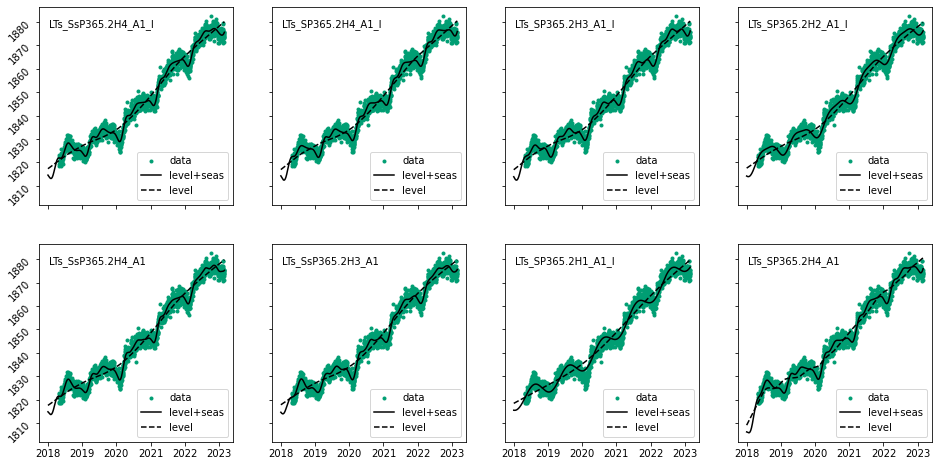

In [27]:
dlm_results.plot_summary(num=8, converged=True, sort='agg',figsize=(16,8))

The DLM Results can be easily saved as a .tar for later use

In [31]:
#rlist.save_archive(path_out+f'{name}_{product_type}_day.tar')

In [28]:
dlm_results.save_archive(path_out+f'{name}.tar')

In [8]:
dlm_results = dlmhelper.data.DLMResultList.load_archive(path_out+"global.tar")

In [9]:
#Load archive
#rlist = DLMResultList.load_archive(path_out+"global_WFMDv1.8_day.tar")

# Plot global annual methane increases

In [10]:
# Definition of colors used
c1 = "#0072B2"

In [11]:
_r = dlm_results.get_best_result(sort="agg")

In [12]:
_r.summary()


################################
Summary for wfmd_global_ensemble
################################
name: wfmd_global_ensemble
time range: 2018-01-01T00:00:00.000 --- 2023-02-28T00:00:00.000

################################


In [34]:
_r.level

array([1817.31875194, 1817.3485331 , 1817.37831426, ..., 1880.0759242 ,
       1880.10970297, 1880.14348137])

In [36]:
# The sampling error is not calculated in this notebook to keep things simple
sampling_error = [2.95916842, 0.24635348, 0.19208639, 0.25882388, 0.2505219 ]

model_error = dlmhelper.tools.model_selection_bias_ALI(dlm_results, percentile=100,years=[2018,2019,2020,2021,2022])

The best model is selected using the "agg" measure as a selection criterion

In [37]:
wfmd_global = dlm_results.get_best_result(sort='agg')

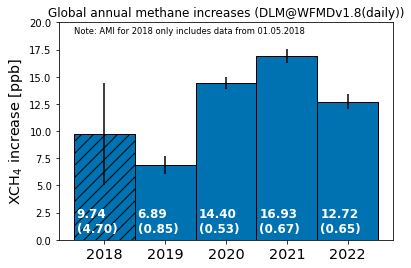

In [39]:
SIGMA = 1


years = np.asarray([2018,2019,2020,2021,2022])
ami = np.zeros(years.shape)
ami_std = np.zeros(years.shape)
total_error = np.zeros(years.shape)

for i, y in enumerate(years):
    ami[i], ami_std[i] = dlmhelper.tools.annual_level_increase(wfmd_global, y)
    total_error[i] = np.sqrt(ami_std[i]**2+model_error[i]**2+sampling_error[i]**2)

fig = plt.figure() 
ax = fig.add_subplot(111)
ax.set_ylim([0,20])
ax.set_ylabel("XCH$_4$ increase [ppb]",fontsize="x-large")
ax.set_xticks(years)
ax.xaxis.set_tick_params(labelsize="x-large")
ax.set_title("Global annual methane increases (DLM@WFMDv1.8(daily))")
ax.bar(years, ami, yerr=SIGMA*(total_error), align ='center', edgecolor='black',color=c1,hatch=["//","","","",""], width=1)

for i, y in enumerate(years):
    ax.text(y-0.45,0.7,f"{ami[i]:.2f}\n({total_error[i]:.2f})",fontsize=12,color="white",fontweight="heavy")
    
#ax.set_title("Global annual methane increases")
ax.text(2017.5,19,"Note: AMI for 2018 only includes data from 01.05.2018",backgroundcolor='white',fontsize="small")
#plt.savefig(path_out+"fig04.png",dpi=300)
plt.show()